# multidms

## Overview of model

The `multidms` model applies to a case where you have DMS datasets for two or more homologs and are interested in identifying shifts in mutational effects between homologs.
To do so, the model defines one homolog as a reference homolog.
For each mutation, the model fits one parameter that quantifies the effect of the mutation in the reference homolog.
For each non-reference homolog, it also fits a shift parameter that quantifies the shift in the mutation's effect in the non-reference homolog relative to the reference.
Shift parameters can be regularized, encouraging most of them to be close to zero.
This regularization step is a useful way to eliminate the effects of experimental noise, and is most useful in cases where you expect most mutations to have the same effects between homologs, such as for homologs that are close relatives.

The model uses a global-epistasis function to disentangle the effects of multiple mutations on the same variant.
To do so, it assumes that mutational effects additively influence a latent biophysical property the protein (e.g., $\Delta G$ of folding).
The mutational-effect parameters described above operate at this latent level.
The global-epistasis function then assumes a sigmoidal relationship between a protein's latent property and its functional score measured in the experiment (e.g., log enrichment score).
Ultimately, mutational parameters, as well as ones controlling the shape of the sigmoid, are all jointly fit to maximize agreement between predicted and observed functional scores acorss all variants of all homologs.

## Detailed description of the model

For each variant $v$ from homolog $h$, we use a global-epistasis function $g$ to convert a latent phenotype $\phi$ to a functional score $f$:

$$f(v,h) = g_{\alpha}(\phi(v,h))$$

where $g$ is a sigmoid and $\alpha$ is a set of parameters encoding the sigmoid.

The latent phenotype is computed in the following way:

$$\phi(v,h) = c + \sum_{m \in v} (x_m + s_{m,h})$$

where:
* $c$ is the wildtype latent phenotype for the reference homolog.
* $x_m$ is the latent phenotypic effect of mutation $m$. See details below.
* $s_{m,h}$ is the shift of the effect of mutation $m$ in homolog $h$. These parameters are fixed to zero for the reference homolog. For non-reference homologs, they are defined in the same way as $x_m$ parameters.
* $v$ is the set of all mutations relative to the reference wildtype sequence (including all mutations that separate homolog $h$ from the reference homolog).

The $x_m$ variable is defined such that mutations are always relative to the reference homolog.
For example, if the wildtype amino acid at site 30 is an A in the reference homolog, and a G in a non-reference homolog, then a Y30G mutation in the non-reference homolog is recorded as an A30G mutation relative to the reference.
This way, each homolog informs the exact same parameters, even at sites that differ in wildtype amino acid.
These are encoded in a `BinaryMap` object, where all sites that are non-identical to the reference are 1's.

Ultimately, we fit parameters using a loss function with one term that scores differences between predicted and observed values and another that uses L1 regularization to penalize non-zero $s_{m,h}$ values:

$$ L_{\text{total}} = \sum_{h} \left[\sum_{v} L_{\text{fit}}(y_{v,h}, f(v,h)) + \lambda \sum_{m} |s_{m,h}|\right]$$

where:
* $L_{\text{total}}$ is the total loss function.
* $L_{\text{fit}}$ is a loss function that penalizes differences in predicted vs. observed functional scores.
* $y_{v,h}$ is the experimentally measured functional score of variant $v$ from homolog $h$.

## Model using matrix algebra

We compute a vector or predicted latent phenotypes $P_{h}$ as:

$$P_{h} = c + (X_h \cdot (β + S_h))$$

where:
* $β$ is a vector of all $β_m$ values.
* $S_h$ is a matrix of all $s_{m,h}$ values.
* $X_h$ is a sparse matrix, where rows are variants, columns are mutations (all defined relative to the reference homolog), and values are weights of 0's and 1's. These weights are used to compute the phenotype of each variant given the mutations present.
* $c$ is the same as above.

In the matrix algebra, the sum of $β_m$ and $S_{m,h}$ gives a vector of mutational effects, with one entry per mutation.
Multiplying the matrix $X_h$ by this vector gives a new vector with one entry per variant, where values are the sum of mutational effects, weighted by the variant-specific weights in $X_h$.
Adding the $c$ value to this vector will give a vector of predicted latent phenotypes for each variant.

Next, the global-epistasis function can be used to convert a vector of predicted latent phenotypes to a vector of predicted functional scores.

$$F_{h,pred} = g_{\alpha}(P_h)$$

Finally, this vector could be fed into a loss function and compared with a vector of observed functional scores.

## Import `Python` modules

In [1]:
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr

from timeit import default_timer as timer
%matplotlib inline

In [2]:
import sys
sys.path.append("..")
from multidms.utils import create_homolog_modeling_data, initialize_model_params
from multidms.model import ϕ, g, prox, cost_smooth

## Implementing the full model with JAX

Below, we implement the $\phi$ and $g$ functions from above.

Next, we initialize values of free parameters for downstream optimization by JAX.

## Simulation Fit

In [3]:
simulated_dataset = pd.read_csv("../results/simulated_dataset_v1.csv")
simulated_dataset.aa_substitutions.fillna("", inplace=True)
simulated_dataset_lib1 = simulated_dataset.query("library == 'lib_1'").copy()
# simulated_dataset_lib1 = simulated_dataset_lib1.sample(n=5000, random_state=23)

In [4]:
simulated_dataset_lib1

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment,homolog
0,lib_1,AAAAAAATTTACGCGA,1,TTA18GTC TTA23TCA TTT41AAC,L18V L23S F41N,3,3,-15.608947,-9.965543,0.001000,reference
1,lib_1,AAAAAACATAGGAGTA,3,TGC19AAG CGG29TCC,C19K R29S,2,2,2.516825,-0.102192,0.931616,reference
2,lib_1,AAAAAAGAGGTTAAAC,1,ATG32TTC,M32F,1,1,3.980341,-0.016995,0.988289,reference
3,lib_1,AAAAAAGGCTTATACT,1,TCA11TCG CGG12GGT GGT46AAA,R12G G46K,3,2,-21.146126,-9.965783,0.001000,reference
4,lib_1,AAAAAATCACTAATAT,3,AGA1ACA CGT15CCG TCC37GCT AGT40TAA TCG42AGC,R1T R15P S37A S40*,5,4,-21.623836,-9.965784,0.001000,reference
...,...,...,...,...,...,...,...,...,...,...,...
74995,lib_1,TTTTTGTAAGGCCTCT,1,AGA1CTT CTG5TCT ATC25GAT GGA50ACA,R1L L5S I25D G50T,4,4,-17.215931,-9.965736,0.001000,H2
74996,lib_1,TTTTTTAATCAGTTAG,3,CCA44ACC,P44T,1,1,0.242479,-0.829286,0.562808,H2
74997,lib_1,TTTTTTCCTAGGAGAT,2,AAC10ACA ATC28TTC,N10T I28F,2,2,-6.999078,-9.028964,0.001914,H2
74998,lib_1,TTTTTTCTACAGAGGT,2,CGC23GGT,R23G,1,1,-0.720320,-1.603013,0.329189,H2


In [5]:
# homologs = json.load(open("../results/homolog_aa_seqs.json", "r"))
# homologs["reference"] = homologs['1']
# homologs["H2"] = homologs['2']
# del homologs['1']
# del homologs['2']

In [6]:
phenotype_for_fitting = "observed_phenotype" # 'observed_enrichment' # 
(X, y), df, all_subs, site_map = create_homolog_modeling_data(
                            simulated_dataset_lib1.sample(n=5000, random_state=23), #, 
                            "homolog", 
                            "reference",
                            "aa_substitutions",
                            phenotype_for_fitting
                        )

Found 0 site(s) lacking data in at least one homolog.
0 of the 5000 variants were removed because they had mutations at the above sites, leaving 5000 variants.


100%|█████████████████████████████████████████████████████| 2405/2405 [00:04<00:00, 586.31it/s]


In [7]:
# Initialize the range and minimum of the sigmoid
# from the global epistasis function using the 5th
# and 95th percentile values from the raw data
sig_upper = simulated_dataset_lib1[phenotype_for_fitting].quantile(0.95)
sig_lower = simulated_dataset_lib1[phenotype_for_fitting].quantile(0.05)
sig_range = sig_upper - sig_lower

# Initialize all params
params = initialize_model_params(
    simulated_dataset_lib1.homolog.unique(), 
    n_beta_shift_params=X["reference"].shape[1],
    include_alpha=True,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)

In [8]:
print(f"\nPre-Optimization")
print(f"----------------")
print(f"cost = {cost_smooth(params, (X, y), λ_ridge=1e-5):.2e}")


Pre-Optimization
----------------
cost = 8.57e+00


Optimize the model params on simulated data.

In [9]:
tol = 1e-6
maxiter = 2000
start = timer()

solver = ProximalGradient(cost_smooth, prox, tol=tol, maxiter=maxiter)
params, state = solver.run(
    params, 
    hyperparams_prox = dict(
        clip_stretch=0.0, 
        lock_params= {
            "S_reference" : jnp.zeros(len(params['β'])),
            "C_reference" : jnp.zeros(shape=(1,))
        }
    ),
    data=(X, y),
    λ_ridge=1e-5
)
end = timer()

print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
print(f"cost = {cost_smooth(params, (X, y)):.2e}")
print(f"Wall time for fit: {end - start}")


Post-Optimization
-----------------
Full model optimization: 2000 iterations
error = 1.85e-03
cost = 8.52e-03
Wall time for fit: 9.364134069997817


Report results of optimization.

In [17]:
for param in ["β", "S_reference", "S_H2"]:
    print(f"\nFit {param} distribution\n===============")
    arr = onp.array(params[param])
    mean = onp.mean(arr)
    median = onp.median(arr)
     
    # measures of dispersion
    min = onp.amin(arr)
    max = onp.amax(arr)
    range = onp.ptp(arr)
    variance = onp.var(arr)
    sd = onp.std(arr)
     
    print("Descriptive analysis")
    print("Measures of Central Tendency")
    print(f"Mean = {mean:.2e}")
    print(f"Median = {median:.2e}")
    print("Measures of Dispersion")
    print(f"Minimum = {min:.2e}")
    print(f"Maximum = {max:.2e}")
    print(f"Range = {range:.2e}")
    print(f"Variance = {variance:.2e}")
    print(f"Standard Deviation = {sd:.2e}")

print(f"\nFit Sigmoid Parameters, α\n================")
for param, value in params['α'].items():
    print(f"{param}: {value}") 

df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_{phenotype_for_fitting}"] = onp.nan

print(f"\nRunning Predictions")
print(f"-------------------")
for homolog, hdf in df.groupby("homolog"):
    
    print(f"C_{homolog}: ", params[f"C_{homolog}"])

    h_params = {"β":params["β"], "S":params[f"S_{homolog}"], "C":params[f"C_{homolog}"]}
    z_h = ϕ(h_params, X[homolog])
    print(z_h.shape)
    print(hdf.index.shape)
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h
    y_h_pred = g(params["α"], z_h)
    df.loc[hdf.index, f"predicted_{phenotype_for_fitting}"] = y_h_pred

print(f"Done")

simulated_mut_effects = pd.read_csv("../results/simulated_mut_effects_v1.csv")


Fit β distribution
Descriptive analysis
Measures of Central Tendency
Mean = -2.92e+00
Median = -2.43e+00
Measures of Dispersion
Minimum = -1.34e+01
Maximum = 2.43e+00
Range = 1.59e+01
Variance = 7.98e+00
Standard Deviation = 2.82e+00

Fit S_reference distribution
Descriptive analysis
Measures of Central Tendency
Mean = 0.00e+00
Median = 0.00e+00
Measures of Dispersion
Minimum = 0.00e+00
Maximum = 0.00e+00
Range = 0.00e+00
Variance = 0.00e+00
Standard Deviation = 0.00e+00

Fit S_H2 distribution
Descriptive analysis
Measures of Central Tendency
Mean = -3.03e-01
Median = -2.08e-01
Measures of Dispersion
Minimum = -3.85e+00
Maximum = 1.97e+00
Range = 5.81e+00
Variance = 4.68e-01
Standard Deviation = 6.84e-01

Fit Sigmoid Parameters, α
ge_bias: [-9.99229725]
ge_scale: [10.04964915]
latent_bias: [5.12081994]

Running Predictions
-------------------
C_H2:  [-0.00250932]
(2405,)
(2405,)
C_reference:  [0.]
(2595,)
(2595,)
Done


<AxesSubplot:ylabel='Count'>

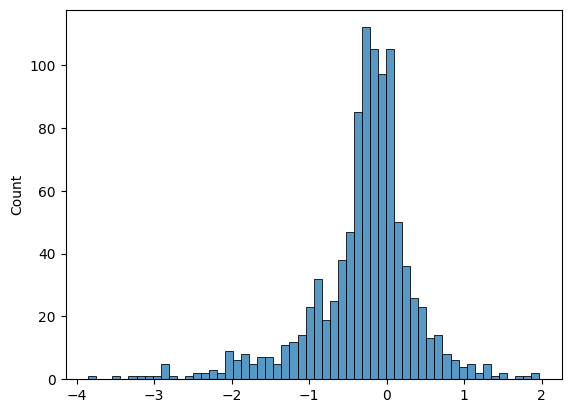

In [11]:
sns.histplot(params["S_H2"])

<AxesSubplot:ylabel='Count'>

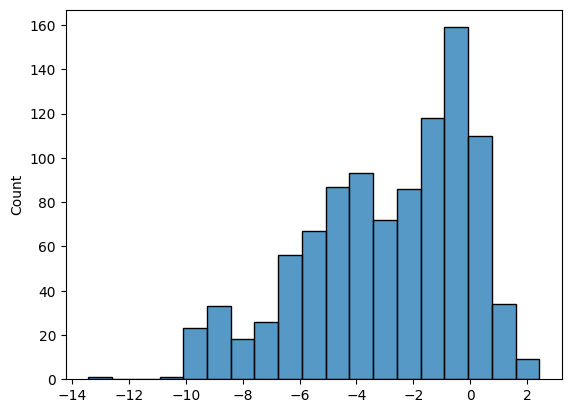

In [12]:
sns.histplot(params["β"])

Make plots comparing simulated and predicted values

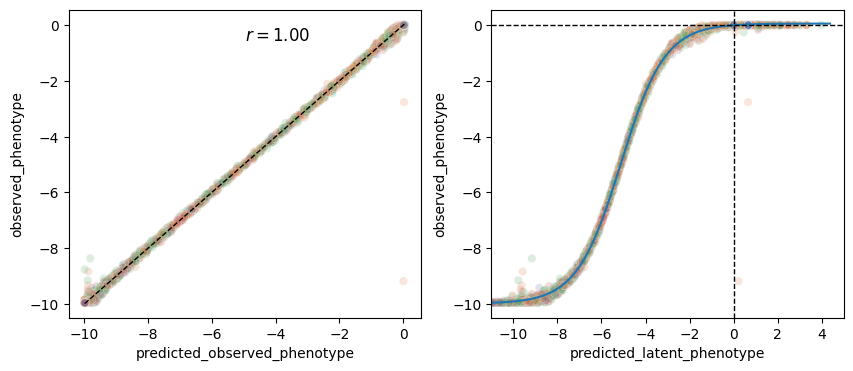

In [13]:
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
sns.scatterplot(
    data=df, x=f"predicted_{phenotype_for_fitting}",
    y=phenotype_for_fitting,
    hue="n_aa_substitutions",
    alpha=0.2, palette="deep", ax=ax[0],
    legend=False
)

lb = df[[phenotype_for_fitting, f"predicted_{phenotype_for_fitting}"]].min().min()
ub = df[[phenotype_for_fitting, f"predicted_{phenotype_for_fitting}"]].max().max()

ax[0].plot([lb, ub], [lb, ub], "k--", lw=1)
r = pearsonr(df[phenotype_for_fitting], df[f'predicted_{phenotype_for_fitting}'])[0]
ax[0].annotate(f"$r = {r:.2f}$", (.5, .9), xycoords="axes fraction", fontsize=12)

# shape 
sns.scatterplot(
    data=df, x="predicted_latent_phenotype",
    y=phenotype_for_fitting,
    hue="n_aa_substitutions",
    alpha=0.2, palette="deep",
    legend=False, ax=ax[1]
)

ϕ_grid = onp.linspace(
    1.1 * df.predicted_latent_phenotype.min(),
    1.1 * df.predicted_latent_phenotype.max(),
    num=1000
)
shape = (ϕ_grid, g(params["α"], ϕ_grid))
ax[1].plot(*shape)
#ax[1].set_ylim(-11, 1)
ax[1].set_xlim(-11, 5)
plt.axhline(0, color="k", ls="--", lw=1)
plt.axvline(0, color="k", ls="--", lw=1)
plt.show()

Plot heatmaps of predicted and simulated mutational parameters.

site          1         2          3         4         5         6   \
mutant                                                                
*      -9.095966 -8.100728 -13.438448 -8.972532 -8.580002 -8.930959   
A      -3.570800 -6.193047  -0.294332 -1.263925 -0.658882 -0.567961   
C      -0.682305 -3.773953  -1.843894 -3.984861 -3.464256 -5.086335   
D      -4.577778 -6.049978   0.781822 -0.264112  0.822324 -0.451771   
E      -2.290517 -2.109786  -2.373108 -4.333831 -4.824664 -5.892474   
F      -5.806152 -1.215574  -2.856559 -0.645568 -0.936011 -2.251511   
G      -1.329143 -6.731369   1.068429 -1.748250 -3.761750 -5.683873   
H      -5.244140 -4.630307  -3.621868 -3.082309 -2.817582  2.433796   
I      -3.218719 -3.258444  -2.617907       NaN -1.699010 -0.491778   
K      -6.395305 -5.908750  -1.224939 -4.166652 -1.620272 -0.699422   
L      -0.773940 -7.006504  -0.671744 -8.604250       NaN -4.511924   
M       0.321692 -3.237974   0.268894 -3.980572  0.402324 -4.445869   
N     

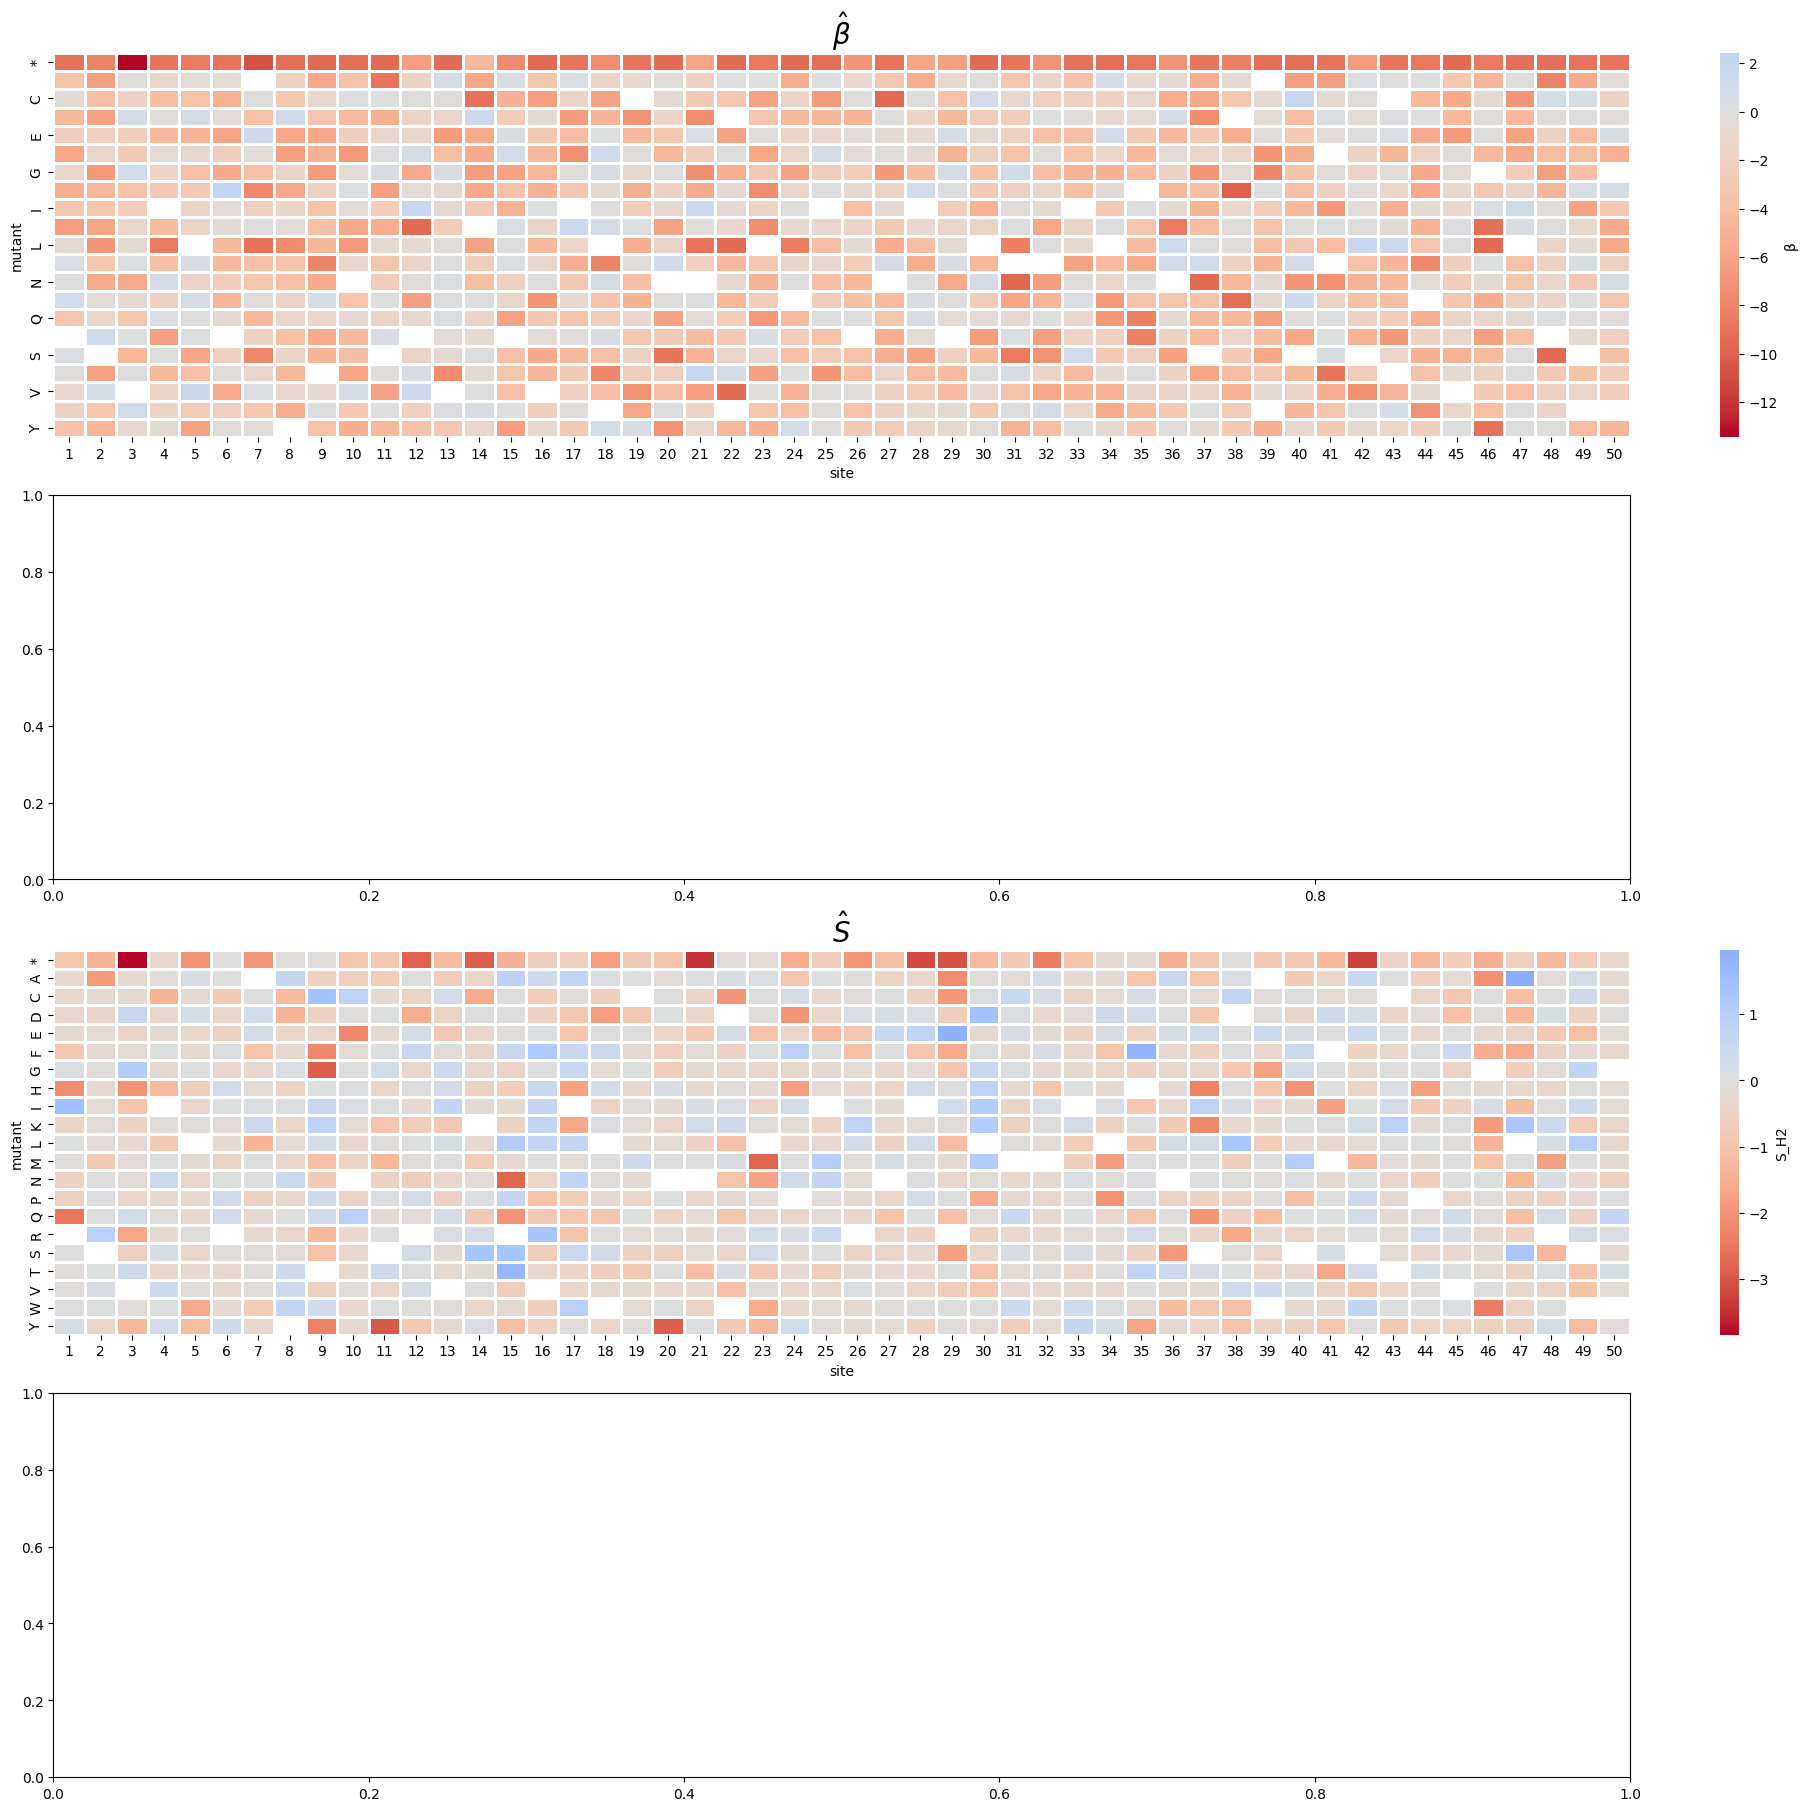

In [16]:
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(18, 18))
axd = fig.subplot_mosaic(
    """
    DDDDDDDDD
    EEEEEEEEE
    GGGGGGGGG
    HHHHHHHHH
    """
)
#     FFFFFFFFF

layout = {
    "β":("D", "$\hat{β}$"),
    "beta_h1":("E", "$β_{H1}$"),
#     "beta_h2":("F", "$β_{H2}$"),
    "S_H2":("G", "$\hat{S}$"),
    "shift":("H", "S")
}

shifted_sites = set(simulated_mut_effects.query("shifted_site == True")["site"])
non_identical_sites = [
    i for i, row in site_map.iterrows()
    if row["reference"] != row["H2"]
]

for i, param in enumerate(["β", "S_H2"]):
    rows = []
    for mutation, p in zip(all_subs, params[param]):
        wt = mutation[0]
        mutant = mutation[-1]
        site = int(mutation[1:-1])
        rows.append([site, wt, mutant, float(p)])

    mutation_effects = pd.DataFrame(
        rows,
        columns=("site", "wildtype", "mutant", param)
    ).pivot(
        index="mutant",
        columns="site", values=param
    )

    sns.heatmap(
        mutation_effects, mask=mutation_effects.isnull(),
        linewidths=1,
        cmap="coolwarm_r", center=0,
        # vmin=-1, vmax=1,
        cbar_kws={"label": param},
        ax=axd[layout[param][0]]
    )

    axd[layout[param][0]].set_title(layout[param][1], size=20)


# for i, param in enumerate(["beta_h1", "beta_h2", "shift"], 2):
for i, param in enumerate(["beta_h1", "shift"], 2):
    

    mutation_effects = simulated_mut_effects.pivot(
        index="mut_aa",
        columns="site", values=param
    )

    sns.heatmap(
        mutation_effects, mask=mutation_effects.isnull(),
        linewidths=1,
        cmap="coolwarm_r", center=0,
        cbar_kws={"label": param},
        ax=axd[layout[param][0]]
    )
    axd[layout[param][0]].set_title(layout[param][1], size=20)


for param, ax in axd.items():
    for site in shifted_sites:
        ax.add_patch(
            plt.Rectangle(
                (site-1, 0), 1, 21, 
                linewidth=3, 
                edgecolor="black" if site in non_identical_sites else "purple",
                fill=False
            )
        )
plt.show()